# Calculate song information contained in individual MA neurons

Because each neuron maps song to a single real number, $r_i = f_i[s(t < t')]$, the mutual info $MI[r_i, s]$ is given simply by the response entropy $H[r_i]$, since

$$MI[r_i, s] = H[r_i] - E_s[H[r_i|s]] = H[r_i]$$

since $H[r_i|s] = H[f_i(s)|s] = 0$, i.e. there is no noise, so each song maps to exactly one neural response value.

In [1]:
%matplotlib inline
from itertools import product as cproduct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys

from disp import set_plot
from record_0_main import smlt_ma


cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

PFX_NRL = f'data/simple/mlv/ma_built/nrl/ma_built_nrl'

Load behavioral data from Coen et al 2014

In [2]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [3]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in ISTRAIN]

df_behav = None

## Define complete neural population

In [4]:
# neural params
TAU_R = np.array([.1, .5, 1, 2, 5, 10, 30, 60, 120, 180, 240, 480, 600])
TAU_A = np.array([.1, .5, 1, 2, 5, 10, 30, 60, np.inf])
X_S = np.array([0, .5, 1])

tau_r_tau_a_x_s = np.array(list(cproduct(TAU_R, TAU_A, X_S)))

tau_rs = tau_r_tau_a_x_s[:, 0]
tau_as = tau_r_tau_a_x_s[:, 1]
x_ss = tau_r_tau_a_x_s[:, 2]
x_ps = 1 - x_ss  # pulse selectivity

params = {'TAU_R': tau_rs, 'TAU_A': tau_as, 'X_S': x_ss, 'X_P': x_ps}

nr = len(tau_rs)
r_cols = [f'R_{cr}' for cr in range(nr)]

## Simulate population recordings

In [5]:
# record data
for itr, df_tr in zip(ISTRAIN, dfs_tr):
    sys.stdout.write('.')
    
    # original songs
    i_s = np.array(df_tr['S']).astype(float)
    i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
    
    rs = smlt_ma(i_s, i_p, params, DT)
    
    df_tr_nrl = df_tr.copy()
    df_tr_nrl[r_cols] = rs

    np.save(f'{PFX_NRL}_tr_{itr}.npy', np.array([{'df': df_tr_nrl}]))
    
    # shuffled songs
    it_shuf = np.random.permutation(len(i_s))
    
    rs = smlt_ma(i_s[it_shuf], i_p[it_shuf], params, DT)

    df_tr_nrl_shuf = df_tr.copy()
    df_tr_nrl_shuf[r_cols] = rs

    np.save(f'{PFX_NRL}_shuf_tr_{itr}.npy', np.array([{'df': df_tr_nrl_shuf}]))

.......................................................................................

# Compute information

In [6]:
R_COLS = [f'R_{ir}' for ir in range(nr)]

In [7]:
# load all neural recordings
dfs_tr = [np.load(f'{PFX_NRL}_tr_{itr}.npy', allow_pickle=True)[0]['df'] for itr in ISTRAIN]

# only keep neural activity after first song onset
it_song_starts = [np.nonzero(np.array(df_tr['Q']) == 0)[0][0] for df_tr in dfs_tr]
frs = cc([np.array(df_tr[R_COLS])[it_song_start:, :] for df_tr, it_song_start in zip(dfs_tr, it_song_starts)])

dfs_tr = None

In [8]:
dfs_tr_shuf = [np.load(f'{PFX_NRL}_shuf_tr_{itr}.npy', allow_pickle=True)[0]['df'] for itr in ISTRAIN]

it_song_starts_shuf = [np.nonzero(np.array(df_tr_shuf['Q']) == 0)[0][0] for df_tr_shuf in dfs_tr_shuf]
frs_shuf = cc([np.array(df_tr_shuf[R_COLS])[it_song_start_shuf:, :] for df_tr_shuf, it_song_start_shuf in zip(dfs_tr_shuf, it_song_starts_shuf)])

dfs_tr_shuf = None

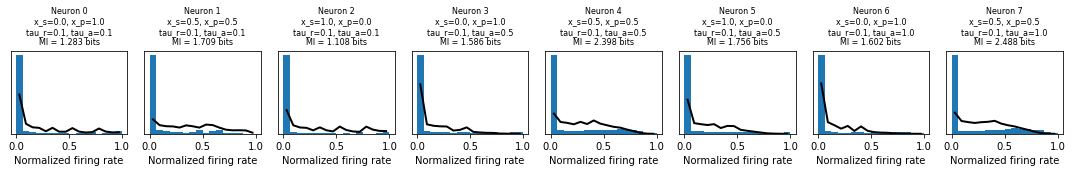

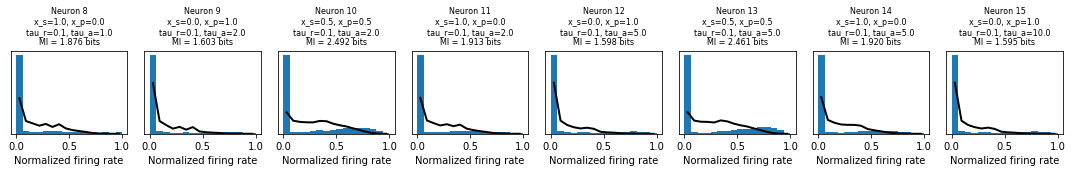

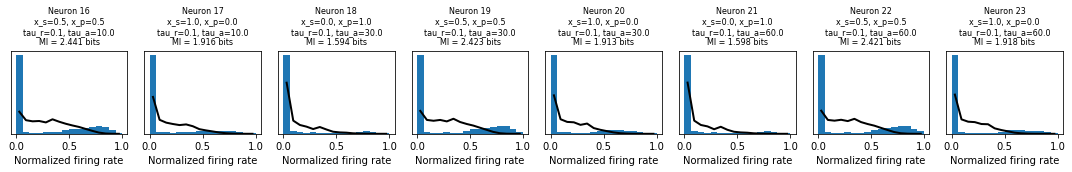

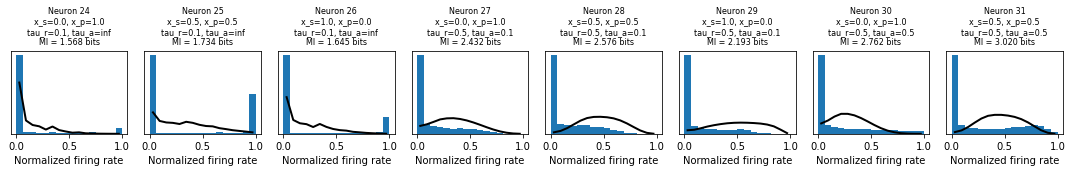

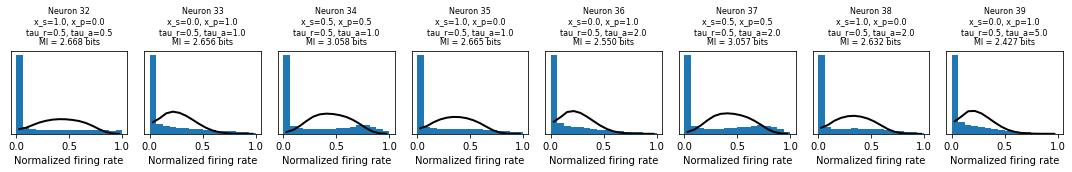

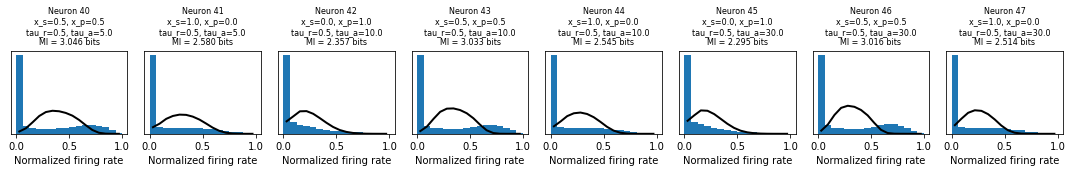

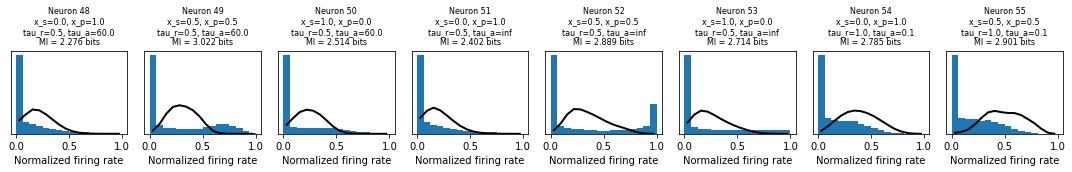

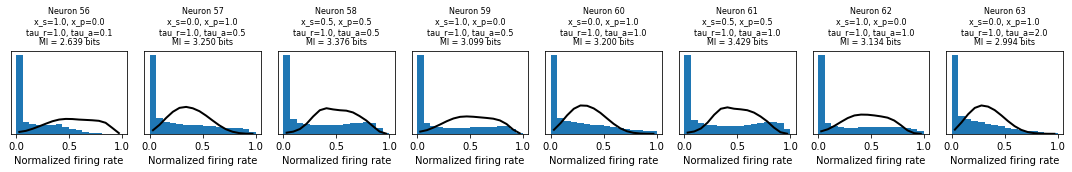

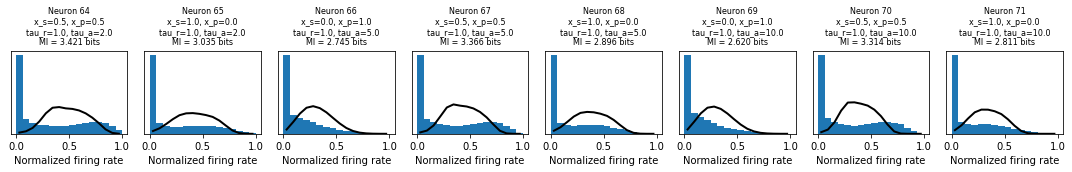

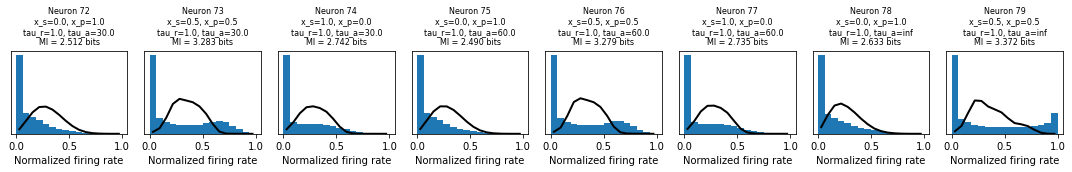

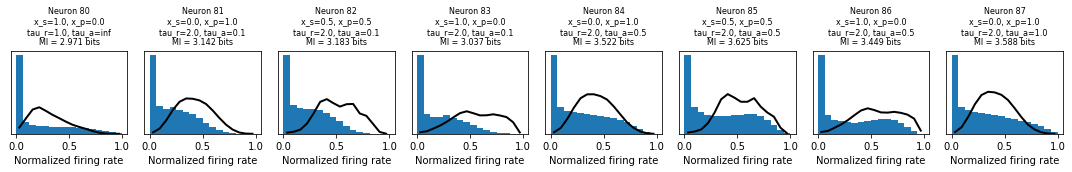

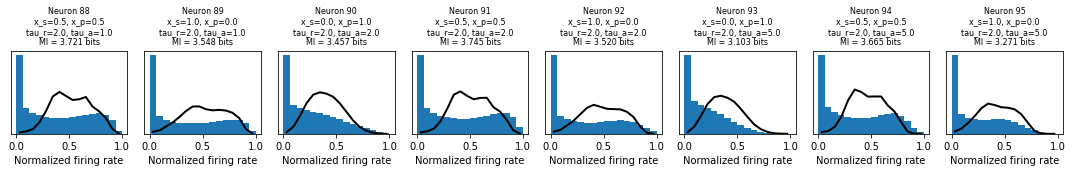

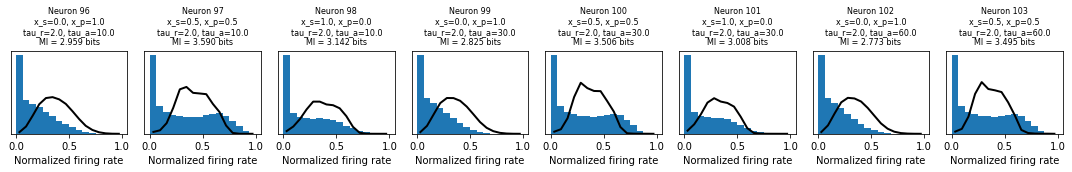

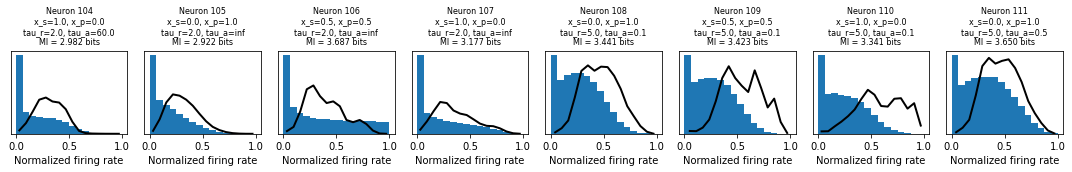

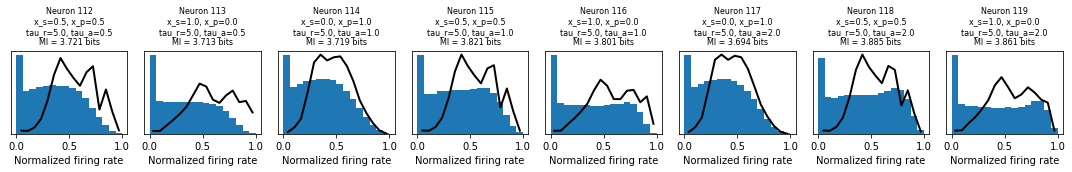

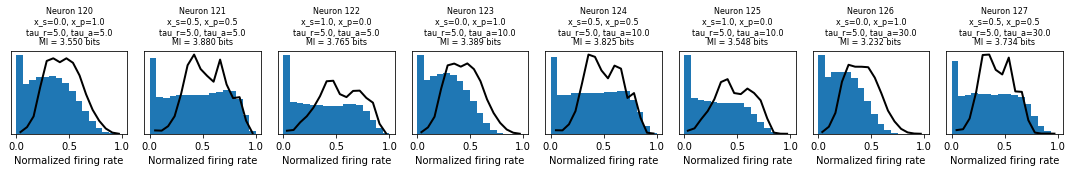

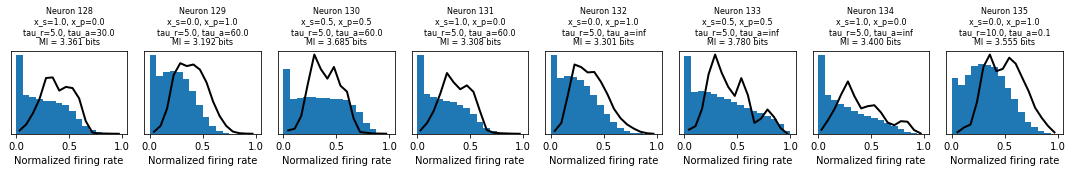

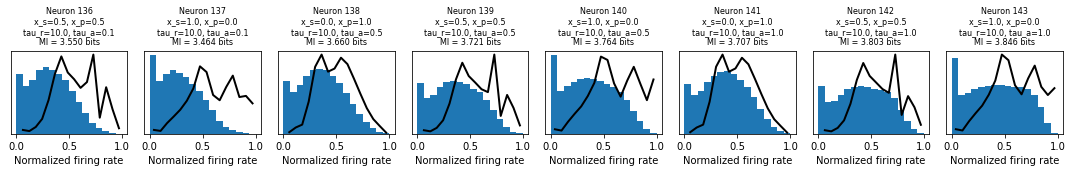

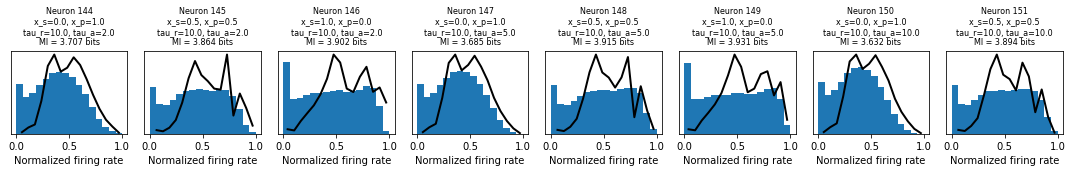

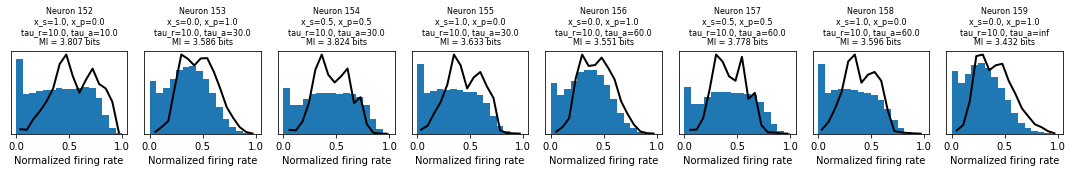

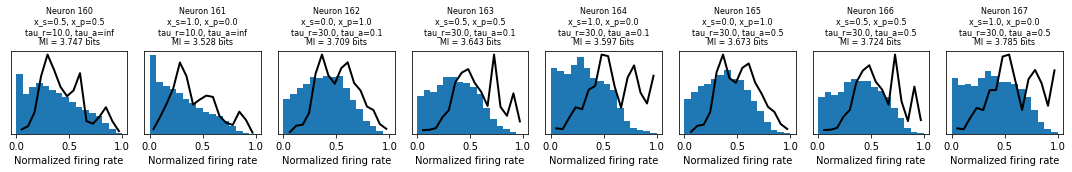

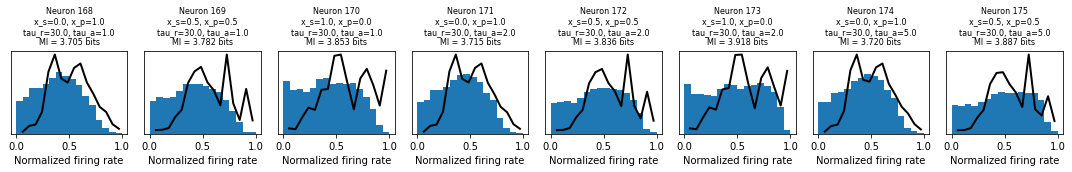

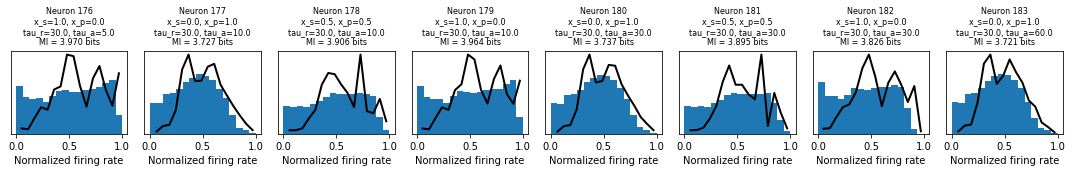

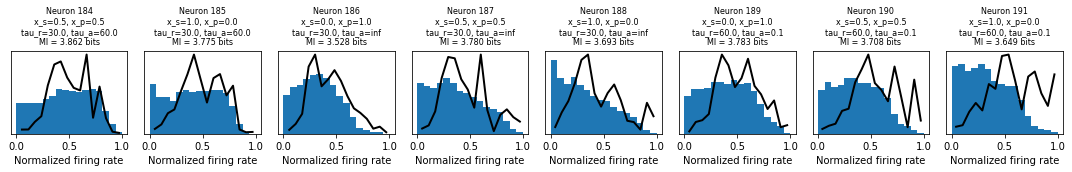

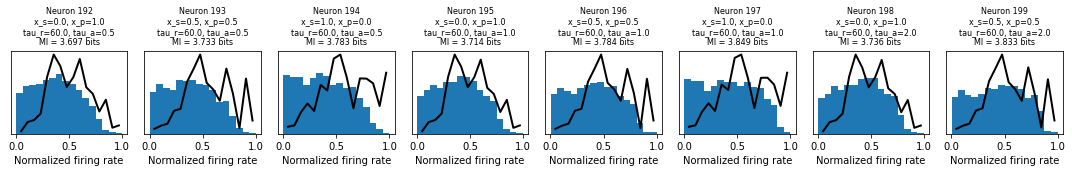

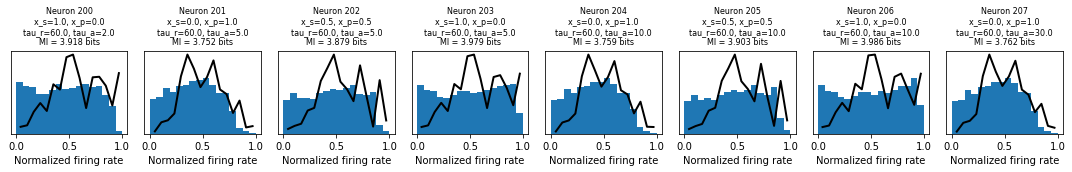

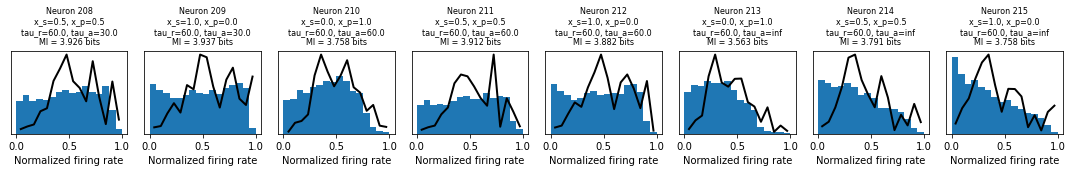

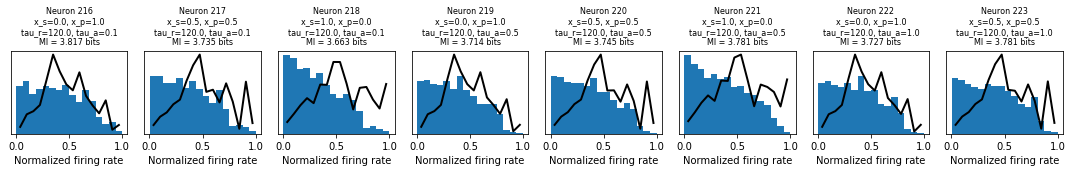

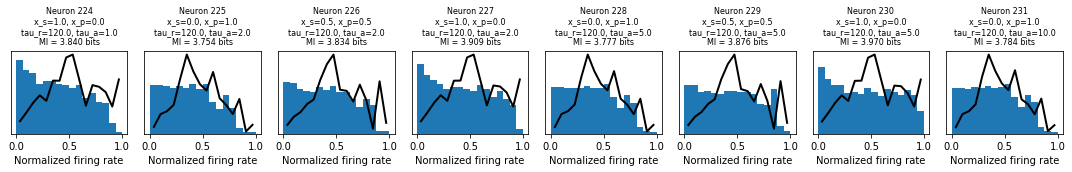

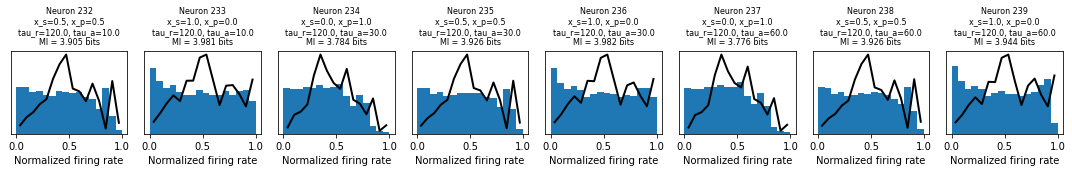

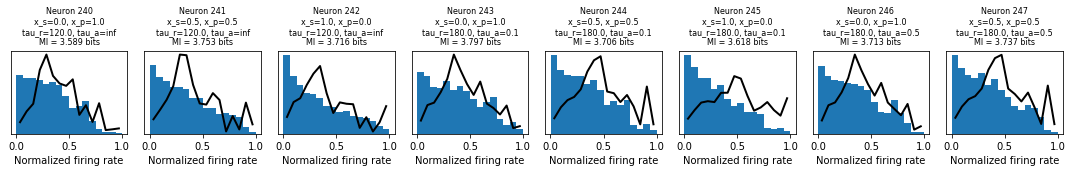

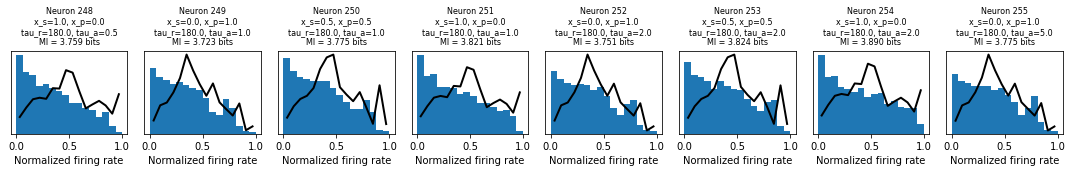

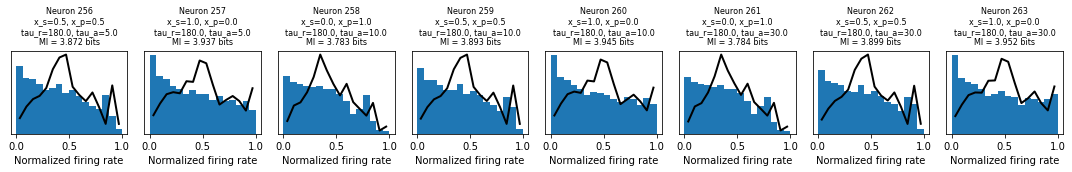

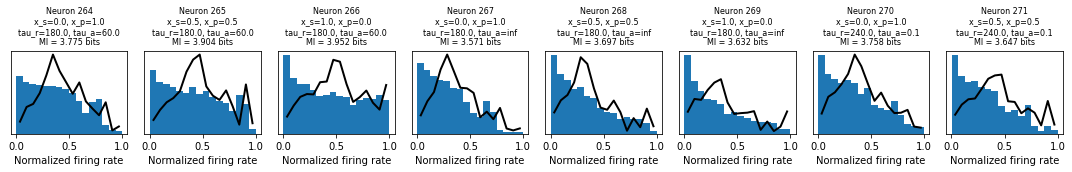

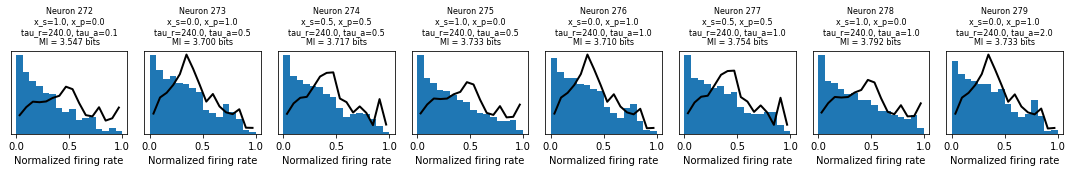

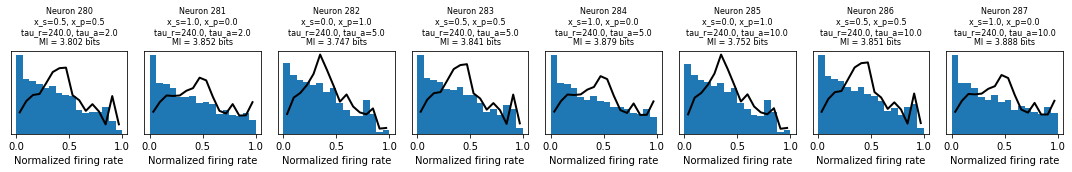

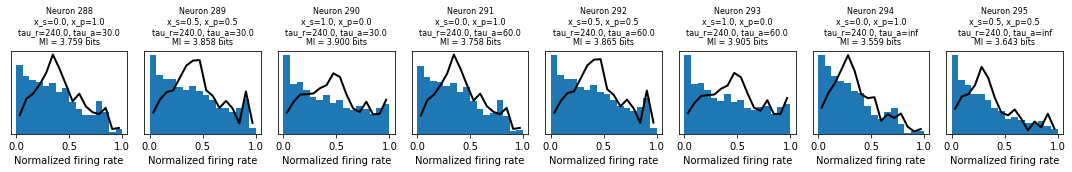

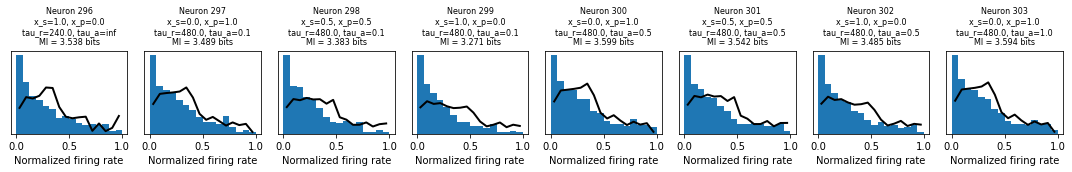

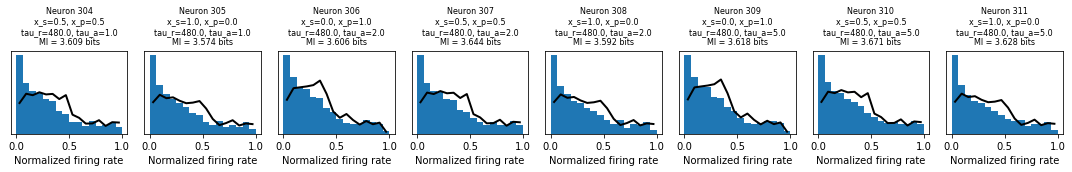

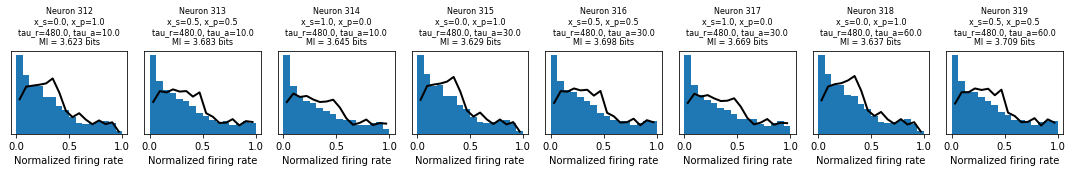

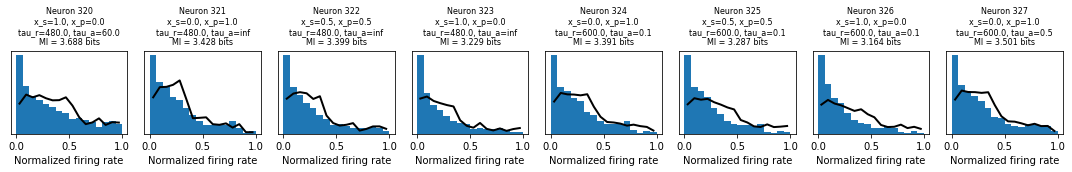

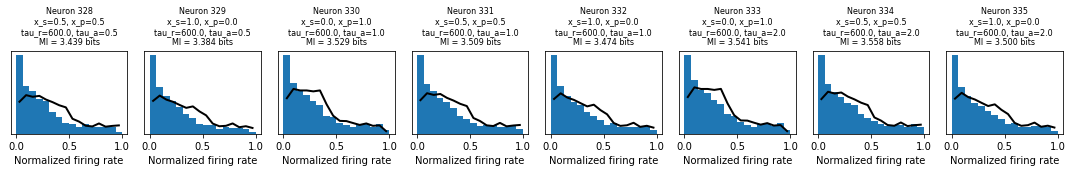

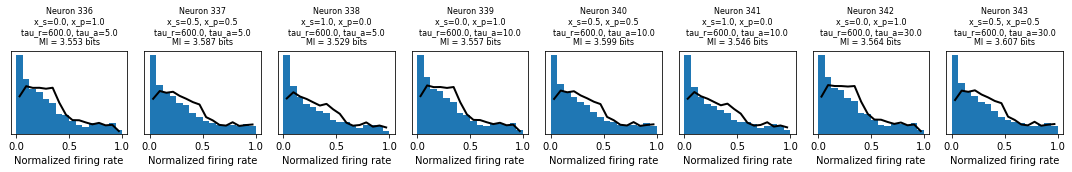

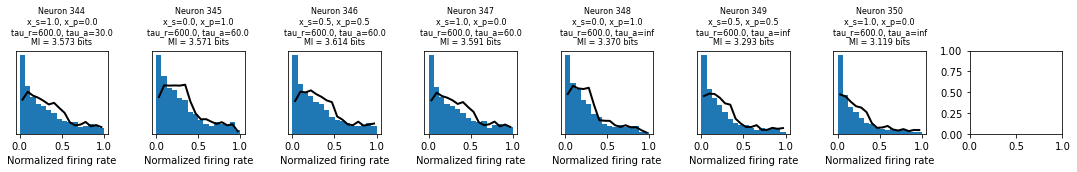

In [9]:
ncol = 8
cnrn = 0
nbin = 16
ents = np.nan * np.zeros(nr)
for istart in range(0, frs.shape[1], ncol):
    fig, axs = plt.subplots(1, ncol, figsize=(15, 2.5), tight_layout=True)
    for ax, fr, fr_shuf in zip(axs, frs[:, istart:istart+ncol].T, frs_shuf[:, istart:istart+ncol].T):
        # song responses
        fr /= fr.max()
        cts_fr, bins = np.histogram(fr, bins=nbin)
        binc = .5*(bins[:-1] + bins[1:])
        p_fr = cts_fr/cts_fr.sum()
        
        ent = stats.entropy(p_fr, base=2)
        ents[cnrn] = ent
        
        ax.bar(binc, p_fr, width=(bins[1] - bins[0]))
        
        # responses to shuffled song
        fr_shuf /= fr_shuf.max()
        cts_fr_shuf, bins = np.histogram(fr_shuf, bins=nbin)
        binc = .5*(bins[:-1] + bins[1:])
        p_fr_shuf = cts_fr_shuf/cts_fr_shuf.sum()
        
        ax.plot(binc, p_fr_shuf, c='k', lw=2)
        
        ax.set_xlabel('Normalized firing rate')
        ax.set_title(f'Neuron {cnrn}\nx_s={x_ss[cnrn]}, x_p={x_ps[cnrn]}\ntau_r={tau_rs[cnrn]:.1f}, tau_a={tau_as[cnrn]:.1f}\nMI = {ent:.3f} bits', fontsize=8)
        ax.yaxis.set_visible(False)
        cnrn += 1

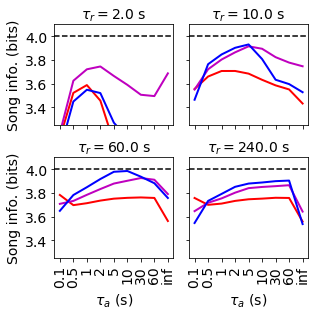

In [10]:
# plot entropy vs TAU_A for several different TAU_R
itau_r = [3, 5, 7, 10]
colors = ['r', 'm', 'b']

fig, axs = plt.subplots(2, 2, figsize=(4.5, 4.5), tight_layout=True, sharex=True, sharey=True)
axs = axs.flatten()

for cax, (ax, tau_r) in enumerate(zip(axs, TAU_R[itau_r])):
    mtau_r = np.isclose(tau_rs, tau_r)
    for x_s, c in zip(X_S, colors):
        mx_s = np.isclose(x_ss, x_s)
        # get tau_as and entropies of responses w/ this tau_r and x_s
        tau_as_ = tau_as[mtau_r & mx_s]
        ents_ = ents[mtau_r & mx_s]
        
        assert list(tau_as_) == sorted(tau_as_)
        
        ax.plot(np.arange(len(TAU_A)), ents_, lw=2, c=c)
        
    ax.axhline(np.log2(nbin), c='k', ls='--')
        
    ax.set_title(r'$\tau_r =$' + f'{tau_r} s')
    
for ax in axs[[0, 2]]:
    ax.set_ylabel('Song info. (bits)')
for ax in axs[[2, 3]]:
    ax.set_xticks(np.arange(len(TAU_A)))
    ax.set_xticklabels([f'{tau_a:.1f}' if tau_a < 1 else f'{tau_a:.0f}' for tau_a in TAU_A], rotation=90)
    ax.set_xlabel(r'$\tau_a$ (s)')
    
for ax in axs:
    ax.set_ylim(bottom=3.25, top=4.1)
    set_plot(ax, font_size=14)
    
fig.savefig('cosyne_2023/2d.svg')

NRN 52, X_S = 0.5, X_P = 0.5, TAU_R = 0.5, TAU_A = inf
NRN 214, X_S = 0.5, X_P = 0.5, TAU_R = 60.0, TAU_A = inf
NRN 205, X_S = 0.5, X_P = 0.5, TAU_R = 60.0, TAU_A = 10.0


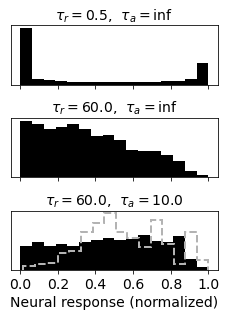

In [11]:
inrns_show = [52, 214, 205]

fig, axs = plt.subplots(3, 1, figsize=(3.25, 4.5), sharex=True, tight_layout=True)

for ax, inrn in zip(axs, inrns_show):
    
    print(f'NRN {inrn}, X_S = {x_ss[inrn]}, X_P = {x_ps[inrn]}, TAU_R = {tau_rs[inrn]}, TAU_A = {tau_as[inrn]}')
    ax.hist(frs[:, inrn], bins=nbin, color='k')
    
    ax.set_title(r'$\tau_r=$' + f'{tau_rs[inrn]},  ' + r'$\tau_a=$' + f'{tau_as[inrn]}')
# overlay shuffled result on final histogram
ax.hist(frs_shuf[:, inrn], bins=nbin, histtype='step', fill=False, color=(.7, .7, .7), lw=2, ls='--')

ax.set_xlabel('Neural response (normalized)')

for ax in axs:
    set_plot(ax, y_ticks=[], font_size=14)
    
fig.savefig('cosyne_2023/2c.svg')